# Predicción de Cantidades Vendidas por Región y Categoría con Prophet

Este notebook replica el flujo de predicción de cantidades vendidas por región y categoría, usando Prophet y considerando variables exógenas (`AVG_PRECIO_LISTA`, `AVG_DESC_PORCENTAJE`). Se generan pronósticos para dos escenarios, siguiendo la lógica de los modelos implementados en Snowflake.

## 1. Importar Librerías y Configuración

Importamos las librerías necesarias y configuramos el logging para trazabilidad.

In [15]:
import pandas as pd
import numpy as np
import snowflake.connector
import logging
from datetime import datetime
import os
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.subplots as sp
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pytz import timezone
import os
from datetime import datetime
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)

## 2. Carga de Datos desde Snowflake

Cargamos los datos históricos y los dos escenarios de forecast desde las vistas generadas en Snowflake.

In [ ]:
def get_snowflake_connection():
    try:
        conn = snowflake.connector.connect(
            user='XXXXXXXXXXXXXXXXXX',  
            password='XXXXXXXXXXXXX',  
            account='XXXXXXXXXXXXX', 
            warehouse='COMPUTE_WH', 
            database='BEBIDAS_PROJECT',
            schema='BEBIDAS_ANALYTICS'
        )
        logging.info("Conexión a Snowflake exitosa")
        return conn
    except Exception as e:
        logging.error(f"Error de conexión a Snowflake: {e}")
        raise

def load_snowflake_views():
    conn = get_snowflake_connection()
    try:
        df_hist = pd.read_sql("SELECT * FROM VW_VENTAS_HISTORICO_M3", conn)
        df_fcst1 = pd.read_sql("SELECT * FROM VW_VENTAS_FCST_FEATURES_1", conn)
        df_fcst2 = pd.read_sql("SELECT * FROM VW_VENTAS_FCST_FEATURES_2", conn)
        logging.info(f"Histórico: {len(df_hist)} registros, Escenario 1: {len(df_fcst1)}, Escenario 2: {len(df_fcst2)}")
        return df_hist, df_fcst1, df_fcst2
    finally:
        conn.close()

df_hist, df_fcst1, df_fcst2 = load_snowflake_views()
print(f"Histórico: {df_hist.shape}, Escenario 1: {df_fcst1.shape}, Escenario 2: {df_fcst2.shape}")

2025-06-28 21:04:56,583 - INFO - Snowflake Connector for Python Version: 3.15.0, Python Version: 3.10.11, Platform: Windows-10-10.0.19045-SP0
2025-06-28 21:04:56,588 - INFO - Connecting to GLOBAL Snowflake domain
2025-06-28 21:04:56,588 - INFO - Connecting to GLOBAL Snowflake domain
2025-06-28 21:04:57,812 - INFO - Conexión a Snowflake exitosa
2025-06-28 21:04:57,812 - INFO - Conexión a Snowflake exitosa
2025-06-28 21:05:03,591 - INFO - Histórico: 3984 registros, Escenario 1: 1680, Escenario 2: 1680
2025-06-28 21:05:03,591 - INFO - Histórico: 3984 registros, Escenario 1: 1680, Escenario 2: 1680


Histórico: (3984, 6), Escenario 1: (1680, 5), Escenario 2: (1680, 5)


In [17]:
producto = "Antioquia-Agua-Agua con Gas 500mL x 6uds"
df_hist = df_hist[df_hist['REGION_CATEGORIA_PRODUCTO'] == producto].copy()
df_fcst1 = df_fcst1[df_fcst1['REGION_CATEGORIA_PRODUCTO'] == producto].copy()
df_fcst2 = df_fcst2[df_fcst2['REGION_CATEGORIA_PRODUCTO'] == producto].copy()

## 3. Preparación de Datos para Prophet

Prophet requiere las columnas `ds` (fecha) y `y` (target). Además, agregamos las variables exógenas.

In [27]:
# Convertir MES a datetime y renombrar columnas
for df in [df_hist, df_fcst1, df_fcst2]:
    df['ds'] = pd.to_datetime(df['MES'])
df_hist['y'] = df_hist['M3_VENDIDOS']

# Seleccionar variables exógenas
exog_vars = ['AVG_PRECIO_LISTA', 'AVG_DESC_PORCENTAJE']
from sklearn.preprocessing import StandardScaler

# Escaladores para exógenas y target
target_scaler = StandardScaler()
exog_scaler = StandardScaler()

# Escalar target (y) y exógenas en el histórico
scaled_y = target_scaler.fit_transform(df_hist[['y']])
scaled_exog = exog_scaler.fit_transform(df_hist[exog_vars])

# Guardar escalado en el histórico
df_hist['y_scaled'] = scaled_y
for idx, var in enumerate(exog_vars):
    df_hist[f'{var}_scaled'] = scaled_exog[:, idx]

# Escalar exógenas en los escenarios
def scale_exog(df):
    scaled = exog_scaler.transform(df[exog_vars])
    for idx, var in enumerate(exog_vars):
        df[f'{var}_scaled'] = scaled[:, idx]
    return df

df_fcst1 = scale_exog(df_fcst1)
df_fcst2 = scale_exog(df_fcst2)

# Variables para Prophet (escaladas)
exog_vars_scaled = [f'{v}_scaled' for v in exog_vars]

## 3.1. Análisis de Variables Exógenas

Para entender por qué el modelo Prophet puede estar generando diferencias importantes entre los escenarios y la serie histórica, es fundamental analizar la evolución de las variables exógenas (`AVG_PRECIO_LISTA`, `AVG_DESC_PORCENTAJE`). Si los valores futuros de estas variables están fuera del rango observado en el histórico, el modelo puede extrapolar de forma poco confiable. A continuación, se grafican estas variables para el histórico y ambos escenarios.

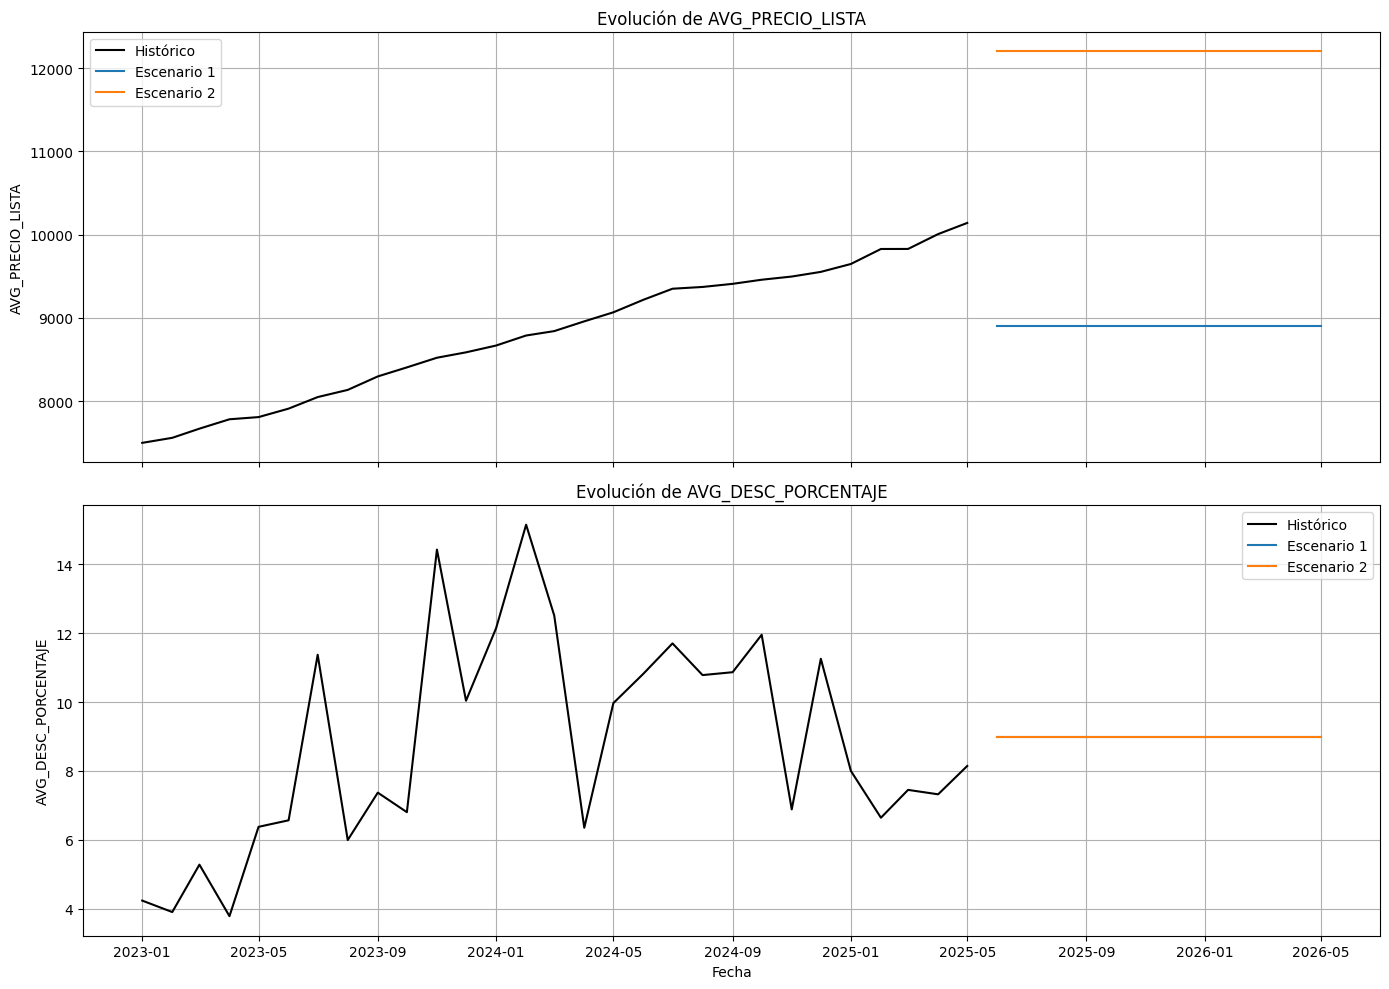

In [19]:


fig, axes = plt.subplots(len(exog_vars), 1, figsize=(14, 5 * len(exog_vars)), sharex=True)
if len(exog_vars) == 1:
    axes = [axes]

for i, var in enumerate(exog_vars):
    axes[i].plot(df_hist['ds'], df_hist[var], label='Histórico', color='black')
    axes[i].plot(df_fcst1['ds'], df_fcst1[var], label='Escenario 1', color='tab:blue')
    axes[i].plot(df_fcst2['ds'], df_fcst2[var], label='Escenario 2', color='tab:orange')
    axes[i].set_title(f'Evolución de {var}')
    axes[i].set_ylabel(var)
    axes[i].legend()
    axes[i].grid(True)
plt.xlabel('Fecha')
plt.tight_layout()
plt.show()

## 4. Entrenamiento del Modelo Prophet con Variables Exógenas

In [20]:
# Instanciar y agregar variables exógenas escaladas
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
for var in exog_vars_scaled:
    m.add_regressor(var)

# Entrenar modelo con target y exógenas escaladas
m.fit(df_hist[['ds', 'y_scaled'] + exog_vars_scaled].rename(columns={'y_scaled': 'y'}))

2025-06-28 21:05:05,714 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2025-06-28 21:05:06,034 - DEBUG - TBB already found in load path
2025-06-28 21:05:06,034 - DEBUG - TBB already found in load path
2025-06-28 21:05:06,091 - INFO - n_changepoints greater than number of observations. Using 22.
2025-06-28 21:05:06,102 - DEBUG - input tempfile: C:\Users\joey_\AppData\Local\Temp\tmpozn1sb__\c4l08r4d.json
2025-06-28 21:05:06,112 - DEBUG - input tempfile: C:\Users\joey_\AppData\Local\Temp\tmpozn1sb__\7y6gxw16.json
2025-06-28 21:05:06,091 - INFO - n_changepoints greater than number of observations. Using 22.
2025-06-28 21:05:06,102 - DEBUG - input tempfile: C:\Users\joey_\AppData\Local\Temp\tmpozn1sb__\c4l08r4d.json
2025-06-28 21:05:06,112 - DEBUG - input tempfile: C:\Users\joey_\AppData\Local\Temp\tmpozn1sb__\7y6gxw16.json
2025-06-28 21:05:06,115 - DEBUG - idx 0
2025-06-28 21:05:06,117 - DEBUG - running CmdStan, num_threads: None
2025-06-28 21:05:06,119 - DEBUG - CmdStan args: ['C:\\Users\\joe

## 5. Predicción para Escenario 1 y Escenario 2

Se generan predicciones para ambos escenarios, usando las variables exógenas correspondientes.

In [21]:
# Preparar dataframes de forecast para Prophet (usando variables escaladas)
def prepare_future_scaled(df_fcst):
    return df_fcst[['ds'] + exog_vars_scaled].copy()

future1 = prepare_future_scaled(df_fcst1)
future2 = prepare_future_scaled(df_fcst2)

# Predicción escenario 1 (escalado)
forecast1 = m.predict(future1)
df_fcst1['CANTIDAD_VENDIDA_PRED_SCALED'] = forecast1['yhat'].values
df_fcst1['CANTIDAD_VENDIDA_PRED'] = target_scaler.inverse_transform(forecast1[['yhat']]).flatten()
df_fcst1['IC_95_LOWER'] = target_scaler.inverse_transform(forecast1[['yhat_lower']]).flatten()
df_fcst1['IC_95_UPPER'] = target_scaler.inverse_transform(forecast1[['yhat_upper']]).flatten()

# Predicción escenario 2 (escalado)
forecast2 = m.predict(future2)
df_fcst2['CANTIDAD_VENDIDA_PRED_SCALED'] = forecast2['yhat'].values
df_fcst2['CANTIDAD_VENDIDA_PRED'] = target_scaler.inverse_transform(forecast2[['yhat']]).flatten()
df_fcst2['IC_95_LOWER'] = target_scaler.inverse_transform(forecast2[['yhat_lower']]).flatten()
df_fcst2['IC_95_UPPER'] = target_scaler.inverse_transform(forecast2[['yhat_upper']]).flatten()

## 6. Métricas de Desempeño en el Histórico Reciente

Se evalúa el modelo en el histórico más reciente (por ejemplo, los últimos 7 meses).

In [22]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Evaluar en los últimos 7 meses del histórico
n_test = 7
test_hist = df_hist.tail(n_test)
future_test = test_hist[['ds'] + exog_vars_scaled]
forecast_test = m.predict(future_test)

# Desescalar valores reales y predichos
y_true = target_scaler.inverse_transform(test_hist[['y_scaled']]).flatten()
y_pred = target_scaler.inverse_transform(forecast_test[['yhat']]).flatten()

print("Evaluación últimos 7 meses del histórico:")
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
print(f"SMAPE: {smape(y_true, y_pred):.2f}%")
print(f"R2: {r2_score(y_true, y_pred):.2f}")

Evaluación últimos 7 meses del histórico:
RMSE: 0.09
MAE: 0.07
SMAPE: 4.60%
R2: 0.90


## 7. Visualización de Resultados

In [23]:
fig = go.Figure()

# 1. Histórico real completo
fig.add_trace(go.Scatter(
    x=df_hist['ds'],
    y=df_hist['y'],
    mode='lines',
    name='Histórico Real',
    line=dict(color='#36332E')
))

# Línea de tendencia (regresión lineal sobre histórico)
X_trend = df_hist['ds'].map(lambda x: x.toordinal()).values.reshape(-1, 1)
y_trend = df_hist['y'].values
reg = LinearRegression().fit(X_trend, y_trend)
y_trend_pred = reg.predict(X_trend)
fig.add_trace(go.Scatter(
    x=df_hist['ds'],
    y=y_trend_pred,
    mode='lines',
    name='Tendencia (Histórico)',
    line=dict(color='gray', dash='dot')
))

# 2. Test real (últimos n_test meses)
fig.add_trace(go.Scatter(
    x=df_hist['ds'].tail(n_test),
    y=y_true,
    mode='lines',
    name='Histórico Test (Real)',
    line=dict(color='#E09C41')
))

# 3. Predicción test (últimos n_test meses)
fig.add_trace(go.Scatter(
    x=df_hist['ds'].tail(n_test),
    y=y_pred,
    mode='lines',
    name='Histórico Test (Predicción)',
    line=dict(color='red', dash='dot')
))

# 4. Forecast Escenario 1
fig.add_trace(go.Scatter(
    x=df_fcst1['ds'],
    y=df_fcst1['CANTIDAD_VENDIDA_PRED'],
    mode='lines',
    name='Forecast Escenario 1',
    line=dict(color='#8B7557'),
    hovertemplate='<b>Fecha</b>: %{x|%Y-%m-%d}<br>' +
                  '<b>Predicción</b>: %{y:.2f}<br>' +
                  '<b>IC 95% Inferior</b>: %{customdata[0]:.2f}<br>' +
                  '<b>IC 95% Superior</b>: %{customdata[1]:.2f}<extra></extra>',
    customdata=np.stack((df_fcst1['IC_95_LOWER'], df_fcst1['IC_95_UPPER']), axis=-1)
))
# Banda de IC 95% Escenario 1
fig.add_trace(go.Scatter(
    x=pd.concat([df_fcst1['ds'], df_fcst1['ds'][::-1]]),
    y=pd.concat([df_fcst1['IC_95_UPPER'], df_fcst1['IC_95_LOWER'][::-1]]),
    fill='toself',
    fillcolor='rgba(139,117,87,0.15)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=True,
    name='IC 95% Escenario 1'
))

# 5. Forecast Escenario 2
fig.add_trace(go.Scatter(
    x=df_fcst2['ds'],
    y=df_fcst2['CANTIDAD_VENDIDA_PRED'],
    mode='lines',
    name='Forecast Escenario 2',
    line=dict(color='#57788B'),
    hovertemplate='<b>Fecha</b>: %{x|%Y-%m-%d}<br>' +
                  '<b>Predicción</b>: %{y:.2f}<br>' +
                  '<b>IC 95% Inferior</b>: %{customdata[0]:.2f}<br>' +
                  '<b>IC 95% Superior</b>: %{customdata[1]:.2f}<extra></extra>',
    customdata=np.stack((df_fcst2['IC_95_LOWER'], df_fcst2['IC_95_UPPER']), axis=-1)
))
# Banda de IC 95% Escenario 2
fig.add_trace(go.Scatter(
    x=pd.concat([df_fcst2['ds'], df_fcst2['ds'][::-1]]),
    y=pd.concat([df_fcst2['IC_95_UPPER'], df_fcst2['IC_95_LOWER'][::-1]]),
    fill='toself',
    fillcolor='rgba(87,120,139,0.15)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=True,
    name='IC 95% Escenario 2'
))

fig.update_layout(
    title=f'Pronóstico de Cantidades Vendidas por Región y Categoría (Prophet)\n{producto}',
    xaxis_title='Fecha',
    yaxis_title='Cantidad Vendida (m3)',
    legend_title='Serie',
    template='plotly_white',
    width=1200,
    height=600
)
fig.show()

## 8. Diferencia porcentual mes a mes y consolidación de resultados


Se calcula y grafica la variación porcentual mes a mes para el histórico y ambos escenarios.

In [24]:
# Calcular diferencias antes de crear df_hist_tabla y los escenarios

def calc_diff(df, col, first_ref=None):
    diffs = df[col].pct_change() * 100
    if first_ref is not None and len(diffs) > 0:
        # Reemplaza el primer valor NaN por la diferencia con el último valor del histórico
        diffs.iloc[0] = 100 * (df[col].iloc[0] - first_ref) / ((abs(df[col].iloc[0]) + abs(first_ref)) / 2)
    return diffs

# Último valor real del histórico (desescalado)
last_hist = target_scaler.inverse_transform(df_hist[['y_scaled']]).flatten()[-1]

# Calcular diferencias
# Histórico: normal
# Escenarios: primer punto vs último histórico
df_hist['DIF_PCT'] = calc_diff(df_hist, 'y')
df_fcst1['DIF_PCT'] = calc_diff(df_fcst1, 'CANTIDAD_VENDIDA_PRED', first_ref=last_hist)
df_fcst2['DIF_PCT'] = calc_diff(df_fcst2, 'CANTIDAD_VENDIDA_PRED', first_ref=last_hist)

# Unificar histórico y escenarios en una sola tabla para análisis y exportación

# Copias para no modificar los originales
df_hist_tabla = df_hist[['ds', 'REGION_CATEGORIA_PRODUCTO', 'y', 'DIF_PCT']].copy()
df_hist_tabla['TIPO'] = 'HISTÓRICO'
df_hist_tabla = df_hist_tabla.rename(columns={'y': 'M3_PRODUCTO'})
df_hist_tabla['IC_95_LOWER'] = np.nan
df_hist_tabla['IC_95_UPPER'] = np.nan

# Escenario 1
sc1 = df_fcst1[['ds', 'REGION_CATEGORIA_PRODUCTO', 'CANTIDAD_VENDIDA_PRED', 'IC_95_LOWER', 'IC_95_UPPER', 'DIF_PCT']].copy()
sc1['TIPO'] = 'ESCENARIO 1'
sc1 = sc1.rename(columns={'CANTIDAD_VENDIDA_PRED': 'M3_PRODUCTO'})

# Escenario 2
sc2 = df_fcst2[['ds', 'REGION_CATEGORIA_PRODUCTO', 'CANTIDAD_VENDIDA_PRED', 'IC_95_LOWER', 'IC_95_UPPER', 'DIF_PCT']].copy()
sc2['TIPO'] = 'ESCENARIO 2'
sc2 = sc2.rename(columns={'CANTIDAD_VENDIDA_PRED': 'M3_PRODUCTO'})

# Unir todo
df_resultados = pd.concat([df_hist_tabla, sc1, sc2], ignore_index=True)

# Split de REGION_CATEGORIA_PRODUCTO
df_resultados[['REGION', 'CATEGORIA', 'PRODUCTO']] = df_resultados['REGION_CATEGORIA_PRODUCTO'].str.split('-', n=2, expand=True)

# Renombrar y reordenar columnas a mayúsculas
df_resultados = df_resultados.rename(columns={
    'REGION_CATEGORIA_PRODUCTO': 'REGION_CATEGORIA_PRODUCTO',
    'ds': 'FECHA',
    'TIPO': 'TIPO',
    'M3_PRODUCTO': 'M3_PRODUCTO',
    'IC_95_LOWER': 'IC_95_LOWER',
    'IC_95_UPPER': 'IC_95_UPPER',
    'DIF_PCT': 'DIF_PCT',
    'REGION': 'REGION',
    'CATEGORIA': 'CATEGORIA',
    'PRODUCTO': 'PRODUCTO'
})

# Orden final de columnas
columnas_final = [
    'REGION_CATEGORIA_PRODUCTO',
    'REGION', 'CATEGORIA', 'PRODUCTO',
    'FECHA', 'TIPO', 'M3_PRODUCTO', 'IC_95_LOWER', 'IC_95_UPPER', 'DIF_PCT'
]
df_resultados = df_resultados[columnas_final]

# Convertir nombres de columnas a mayúsculas (por si acaso)
df_resultados.columns = [c.upper() for c in df_resultados.columns]

# Mostrar tabla final
print(df_resultados.head())
df_resultados


get_colors = lambda difs: [
    'green' if d > 0 else 'yellow' if d == 0 else 'red' for d in difs
]

fig = sp.make_subplots(
    rows=3, cols=1, 
    subplot_titles=['Histórico', 'Escenario 1', 'Escenario 2'],
    vertical_spacing=0.12
)

# 1. Histórico
fig.add_trace(
    go.Bar(
        x=df_hist['ds'],
        y=df_hist['DIF_PCT'],
        marker_color=get_colors(df_hist['DIF_PCT']),
        text=[f'{v:.1f}%' if not pd.isnull(v) else '' for v in df_hist['DIF_PCT']],
        textposition='outside',
        name='Histórico',
        width=20*24*60*60*1000
    ), row=1, col=1
)
# 2. Escenario 1
fig.add_trace(
    go.Bar(
        x=df_fcst1['ds'],
        y=df_fcst1['DIF_PCT'],
        marker_color=get_colors(df_fcst1['DIF_PCT']),
        text=[f'{v:.1f}%' if not pd.isnull(v) else '' for v in df_fcst1['DIF_PCT']],
        textposition='outside',
        name='Escenario 1',
        width=20*24*60*60*1000
    ), row=2, col=1
)
# 3. Escenario 2
fig.add_trace(
    go.Bar(
        x=df_fcst2['ds'],
        y=df_fcst2['DIF_PCT'],
        marker_color=get_colors(df_fcst2['DIF_PCT']),
        text=[f'{v:.1f}%' if not pd.isnull(v) else '' for v in df_fcst2['DIF_PCT']],
        textposition='outside',
        name='Escenario 2',
        width=20*24*60*60*1000
    ), row=3, col=1
)

fig.update_layout(
    title_text='Diferencia porcentual mes a mes',
    showlegend=False,
    height=1300,
    width=1200,
    bargap=0.25,
    font=dict(size=12),
    margin=dict(t=40, l=40, r=40, b=40)
)
for i in range(1, 4):
    fig.update_yaxes(title_text='% Dif.', row=i, col=1, zeroline=True, zerolinecolor='gray')
    fig.update_xaxes(tickformat='%b-%Y', row=i, col=1, tickangle=45)
fig.show()

                  REGION_CATEGORIA_PRODUCTO     REGION CATEGORIA  \
0  Antioquia-Agua-Agua con Gas 500mL x 6uds  Antioquia      Agua   
1  Antioquia-Agua-Agua con Gas 500mL x 6uds  Antioquia      Agua   
2  Antioquia-Agua-Agua con Gas 500mL x 6uds  Antioquia      Agua   
3  Antioquia-Agua-Agua con Gas 500mL x 6uds  Antioquia      Agua   
4  Antioquia-Agua-Agua con Gas 500mL x 6uds  Antioquia      Agua   

                    PRODUCTO      FECHA       TIPO  M3_PRODUCTO  IC_95_LOWER  \
0  Agua con Gas 500mL x 6uds 2023-01-01  HISTÓRICO        1.014          NaN   
1  Agua con Gas 500mL x 6uds 2023-02-01  HISTÓRICO        0.819          NaN   
2  Agua con Gas 500mL x 6uds 2023-03-01  HISTÓRICO        0.903          NaN   
3  Agua con Gas 500mL x 6uds 2023-04-01  HISTÓRICO        0.975          NaN   
4  Agua con Gas 500mL x 6uds 2023-05-01  HISTÓRICO        0.969          NaN   

   IC_95_UPPER    DIF_PCT  
0          NaN        NaN  
1          NaN -19.230769  
2          NaN  10.256410 

In [25]:
print(df_resultados.shape)
df_resultados

(53, 10)


,REGION_CATEGORIA_PRODUCTO,REGION,CATEGORIA,PRODUCTO,FECHA,TIPO,M3_PRODUCTO,IC_95_LOWER,IC_95_UPPER,DIF_PCT
0,Antioquia-Agua-Agua con Gas 500mL x 6uds,Antioquia,Agua,Agua con Gas 500mL x 6uds,2023-01-01,HISTÓRICO,1.014000,NaN,NaN,NaN
1,Antioquia-Agua-Agua con Gas 500mL x 6uds,Antioquia,Agua,Agua con Gas 500mL x 6uds,2023-02-01,HISTÓRICO,0.819000,NaN,NaN,-19.230769
2,Antioquia-Agua-Agua con Gas 500mL x 6uds,Antioquia,Agua,Agua con Gas 500mL x 6uds,2023-03-01,HISTÓRICO,0.903000,NaN,NaN,10.256410
3,Antioquia-Agua-Agua con Gas 500mL x 6uds,Antioquia,Agua,Agua con Gas 500mL x 6uds,2023-04-01,HISTÓRICO,0.975000,NaN,NaN,7.973422
4,Antioquia-Agua-Agua con Gas 500mL x 6uds,Antioquia,Agua,Agua con Gas 500mL x 6uds,2023-05-01,HISTÓRICO,0.969000,NaN,NaN,-0.615385
5,Antioquia-Agua-Agua con Gas 500mL x 6uds,Antioquia,Agua,Agua con Gas 500mL x 6uds,2023-06-01,HISTÓRICO,0.813000,NaN,NaN,-16.099071
6,Antioquia-Agua-Agua con Gas 500mL x 6uds,Antioquia,Agua,Agua con Gas 500mL x 6uds,2023-07-01,HISTÓRICO,0.933000,NaN,NaN,14.760148
7,Antioquia-Agua-Agua con Gas 500mL x 6uds,Antioquia,Agua,Agua con Gas 500mL x 6uds,2023-08-01,HISTÓRICO,1.296000,NaN,NaN,38.906752
8,Antioquia-Agua-Agua con Gas 500mL x 6uds,Antioquia,Agua,Agua con Gas 500mL x 6uds,2023-09-01,HISTÓRICO,0.855000,NaN,NaN,-34.027778
9,Antioquia-Agua-Agua con Gas 500mL x 6uds,Antioquia,Agua,Agua con Gas 500mL x 6uds,2023-10-01,HISTÓRICO,1.011000,NaN,NaN,18.245614


## 9. Almacenar Resultados

Guardamos las predicciones y métricas en Snowflake utilizando `COPY INTO` en las predicciones e `INSERT INTO` para las métricas

In [26]:
import time
from datetime import datetime

def export_prophet_results_to_snowflake(df_resultados, df_hist, y_true, y_pred, producto):
    conn = get_snowflake_connection()
    cursor = conn.cursor()
    timestamp_str = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    temp_csv_path = 'temp_prophet_resultados.csv'
    temp_metrics_path = 'temp_prophet_metrics.csv'
    try:
        # 1. Crear tabla de resultados
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS PROPHET_M3_RESULTADOS (
                ID INTEGER AUTOINCREMENT,
                TIMESTAMP_COL TIMESTAMP_NTZ,
                REGION_CATEGORIA_PRODUCTO VARCHAR(300),
                REGION VARCHAR(100),
                CATEGORIA VARCHAR(100),
                PRODUCTO VARCHAR(100),
                FECHA DATE,
                TIPO VARCHAR(30),
                M3_PRODUCTO FLOAT,
                IC_95_LOWER FLOAT,
                IC_95_UPPER FLOAT,
                DIF_PCT FLOAT
            )
        """)
        # 2. Crear tabla de métricas
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS PROPHET_M3_METRICS (
                ID INTEGER AUTOINCREMENT,
                TIMESTAMP_COL TIMESTAMP_NTZ,
                REGION_CATEGORIA_PRODUCTO VARCHAR(300),
                RMSE FLOAT,
                MAE FLOAT,
                SMAPE FLOAT,
                R2 FLOAT,
                QUALITY VARCHAR(20)
            )
        """)
        # 3. Exportar resultados (TRUNCATE + COPY INTO)
        df_resultados['TIMESTAMP_COL'] = timestamp_str
        cols_result = ['TIMESTAMP_COL'] + [c for c in df_resultados.columns]
        df_resultados[cols_result].to_csv(temp_csv_path, index=False, header=False, encoding='utf-8')
        cursor.execute(f"PUT file://{temp_csv_path} @~/prophet_stage AUTO_COMPRESS = TRUE OVERWRITE = TRUE")
        cursor.execute("TRUNCATE TABLE PROPHET_M3_RESULTADOS")
        cursor.execute(f"""
            COPY INTO PROPHET_M3_RESULTADOS (TIMESTAMP_COL, REGION_CATEGORIA_PRODUCTO, REGION, CATEGORIA, PRODUCTO, FECHA, TIPO, M3_PRODUCTO, IC_95_LOWER, IC_95_UPPER, DIF_PCT)
            FROM @~/prophet_stage/{temp_csv_path}.gz
            FILE_FORMAT = (TYPE = 'CSV' FIELD_DELIMITER = ',' SKIP_HEADER = 0 FIELD_OPTIONALLY_ENCLOSED_BY = '"')
        """)
        # 4. Calcular métricas globales para la región-categoría-producto actual
        from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
        def smape(y_true, y_pred):
            return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        smape_val = smape(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        # Lógica de calidad
        if (r2 >= 0.8) and (smape_val < 20):
            quality = 'BUENO'
        elif (r2 >= 0.5) or (smape_val < 30):
            quality = 'ACEPTABLE'
        else:
            quality = 'POBRE'
        # 5. Exportar métricas (INSERT INTO por COPY INTO)
        metrics_row = [[timestamp_str, producto, rmse, mae, smape_val, r2, quality]]
        import csv
        with open(temp_metrics_path, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerows(metrics_row)
        cursor.execute(f"PUT file://{temp_metrics_path} @~/prophet_stage AUTO_COMPRESS = TRUE OVERWRITE = TRUE")
        cursor.execute(f"""
            COPY INTO PROPHET_M3_METRICS (TIMESTAMP_COL, REGION_CATEGORIA_PRODUCTO, RMSE, MAE, SMAPE, R2, QUALITY)
            FROM @~/prophet_stage/{temp_metrics_path}.gz
            FILE_FORMAT = (TYPE = 'CSV' FIELD_DELIMITER = ',' SKIP_HEADER = 0 FIELD_OPTIONALLY_ENCLOSED_BY = '"')
        """)
        conn.commit()
        print('Exportación a Snowflake completada.')
    except Exception as e:
        conn.rollback()
        print(f'Error al exportar a Snowflake: {e}')
    finally:
        cursor.close()
        conn.close()
        import os
        if os.path.exists(temp_csv_path):
            os.remove(temp_csv_path)
        if os.path.exists(temp_metrics_path):
            os.remove(temp_metrics_path)

# Exportar resultados y métricas a Snowflake
export_prophet_results_to_snowflake(df_resultados, df_hist, y_true, y_pred, producto)

def print_snowflake_counts():
    try:
        conn = get_snowflake_connection()
        cursor = conn.cursor()
        cursor.execute('SELECT COUNT(*) FROM PROPHET_M3_RESULTADOS')
        count_resultados = cursor.fetchone()[0]
        print(f'Número de Registros: {count_resultados}')
        cursor.execute('SELECT COUNT(*) FROM PROPHET_M3_METRICS')
        count_metrics = cursor.fetchone()[0]
        print(f'Número de Registros: {count_metrics}')
        cursor.close()
        conn.close()
    except Exception as e:
        print(f'Error al consultar tablas en Snowflake: {e}')

# Llamar solo una vez para evitar duplicados
print_snowflake_counts()


2025-06-28 21:05:08,108 - INFO - Snowflake Connector for Python Version: 3.15.0, Python Version: 3.10.11, Platform: Windows-10-10.0.19045-SP0
2025-06-28 21:05:08,111 - INFO - Connecting to GLOBAL Snowflake domain
2025-06-28 21:05:08,854 - INFO - Conexión a Snowflake exitosa


Exportación a Snowflake completada.


2025-06-28 21:05:16,477 - INFO - Snowflake Connector for Python Version: 3.15.0, Python Version: 3.10.11, Platform: Windows-10-10.0.19045-SP0
2025-06-28 21:05:16,479 - INFO - Connecting to GLOBAL Snowflake domain
2025-06-28 21:05:17,293 - INFO - Conexión a Snowflake exitosa


Número de Registros: 53
Número de Registros: 11
